What are neuronal avalanches?

"Avalanches" are bursts of neural activity that:

Are temporally clustered

Span a range of sizes and durations

Follow power-law distributions, a hallmark of critical systems

Their detection requires:

No imposed timescale (should emerge from the dynamics)

Aperiodic activity (no rhythmic drive like theta)

Assumption: the system is in a metastable regime near a phase transition (not too silent, not epileptiform)

⚡ Why is theta a problem?

Theta (~6–10 Hz in rodents) is:

Strongly present in the hippocampus during locomotion and exploration

A global clocking signal that drives both pyramidal cells and interneurons

Enforces a periodic structure on spike timing and LFPs

This creates several problems:

1. Breaks temporal scale invariance:

Avalanches are defined by their scale-free timing.

Theta imposes a fixed timescale (~100 ms) → disrupts the scale-invariant cascade detection.

2. Creates artificial temporal clustering:

Activity appears clustered at theta peaks (esp. in pyramidal cells).

So if you bin spikes (e.g. by time), it might falsely appear like "avalanches" when in fact you’re seeing theta phase-locked activity.

3. Violates assumptions of Poisson-like baseline:

Many avalanche detection methods assume background is roughly stationary or Poisson-like.

Theta-modulated spiking violates that: it's strongly rhythmic and non-stationary.

🧪 What are possible workarounds?

Restrict to non-theta epochs: e.g., rest or sleep without theta

Use methods that account for oscillations (rare and experimental)

Focus on brain regions without dominant rhythmicity

Try detecting nested criticality within theta cycles — e.g., avalanches nested within theta troughs (some studies try this, but it's controversial and tricky)

💡 Related deeper idea:

Theta could be seen as a regime switcher:

During theta (exploration) → structured, clocked dynamics

During off-theta (e.g., rest, sleep) → more critical, spontaneous dynamics may emerge

This aligns with ideas of brain operating in multiple regimes, with criticality more evident in default, idling, or slow-wave states.

Want to go into more detail? I can:

show you a canonical avalanche detection pipeline and where theta interferes

summarize a few key papers that tried it in cortex vs hippocampus

discuss criticality vs oscillations in terms of dynamical systems theory

Just tell me which path you prefer 💥

You said:
i mean spike avalanches
ChatGPT said:

Perfect — that clarifies everything. Let's focus on spike avalanches specifically.

🔥 TL;DR:

Your PI is right: theta oscillations impose a strong rhythmic structure on spike timing, which violates core assumptions of avalanche detection — namely, that spikes occur spontaneously and that cascade size/distribution emerges without external or intrinsic rhythms. In theta, pyramidal and interneuron spikes are phase-locked, leading to artificial clustering that can mimic or distort avalanche structure.

🧠 Spike Avalanches: What do we assume?

Spikes should reflect self-organized population dynamics.

You typically:

Bin spikes into small windows (e.g., 2–10 ms)

Define an "avalanche" as a sequence of consecutive active bins (≥1 spike), separated by silent bins

Measure size (spikes per avalanche) and duration (number of bins)

True avalanche dynamics should show power-law distributions of size and duration, ideally with critical branching (mean branching ratio ≈ 1).

But...

⚠️ How Theta Messes This Up
1. Phase-locking creates periodic spike bursts

CA1 pyramidal cells tend to fire at specific theta phases.

Interneurons are even more strongly modulated.

This means spikes cluster every ~100–150 ms → artificially structured timing.

👉 When you bin the spikes, you'll likely see:

Clusters every theta cycle

"Silent" periods in between

Looks just like an avalanche, but it’s driven by theta, not emergent.

2. Avalanche statistics get biased

The presence of theta creates excess of specific-sized avalanches (e.g., one theta cycle long).

This causes deviations from power-law behavior — sometimes even creating apparent bumps in the distribution (a classic red flag of periodic contamination).

You might falsely detect "subcritical" or "supercritical" regimes, depending on bin size and theta alignment.

3. Bin size dependence is broken

In proper avalanche analysis, results should be robust to a range of bin sizes (especially the critical bin size, often set to mean ISI).

Theta imposes a preferred binning scale (~100 ms), which interferes with bin-sweeping methods used to establish true criticality.

💡 Deeper insight:

The core issue is rhythmic structure vs. critical dynamics:

Criticality = no characteristic timescale (scale-invariant)

Theta = strong characteristic timescale (~8 Hz)

Thus, hippocampal theta shifts the network away from the assumptions of criticality, or at least makes it hard to observe it in raw spike trains

🧪 What you can try

If you're still curious about criticality in hippocampus:

Restrict analysis to non-theta periods (e.g., immobility, slow-wave sleep, post-SWR)

Subsample spikes from interneurons, which are less sparse and possibly less phase-modulated

Try to de-phase spikes (e.g., theta-cycle aligned shuffling, though this is controversial)

Use filtered avalanche detection methods that remove rhythmicity or control for it

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import csv
from scipy.signal import resample_poly

from pathlib import Path
import glob
import shutil
import os
import pickle

import sys
sys.path.append('/storage3/eva/code/neuropixels/src')
import path_formatting as pf
import motive
import oe

In [216]:
date = "20250717" # change this according to ur session
animal = "eb02"

oe_sr = 30000
m_sr = 120

pyr = [7,26,45,53,56,64,68,79,83,89,90,115,125,137,167,178,183,189,228,230,232,233,234,256,403,414,426,427,428,429,430,434,441,444,445,446,455,457,458,460,470,471,472,473,474,475,476,477,494,495,512,513,516,519,545]
inter = [70,78,105,110,138,153,154,204,220,227,492,493]

csv_path = rf'X:\eva\data\processed\{animal}\{animal}_{date}\motive\out_csv'
csv_path = pf.w2l(csv_path)

dat_path = rf'X:\eva\data\raw\oe\{animal}\{animal}_{date}\continuous.dat'
dat_path = pf.w2l(dat_path)

ks_path = rf'X:\eva\data\processed\{animal}\{animal}_{date}\kilosort'
ks_path = pf.w2l(ks_path)

res_path = rf'X:\eva\code\neuropixels\results\{animal}\{animal}_{date}'
res_path = pf.w2l(res_path)
os.makedirs(res_path, exist_ok=True) # Create the folder if it doesn't exist

pitch_path = Path(res_path) / "pitch"
pitch_path.mkdir(parents=True, exist_ok=True) # Create the folder if it doesn't exist

csv_path, dat_path, ks_path, res_path, pitch_path

('/storage3/eva/data/processed/eb02/eb02_20250717/motive/out_csv',
 '/storage3/eva/data/raw/oe/eb02/eb02_20250717/continuous.dat',
 '/storage3/eva/data/processed/eb02/eb02_20250717/kilosort',
 '/storage3/eva/code/neuropixels/results/eb02/eb02_20250717',
 PosixPath('/storage3/eva/code/neuropixels/results/eb02/eb02_20250717/pitch'))

In [217]:
goodspiketimes = oe.ks_load(ks_path)
res_path_path = Path(res_path)
with open(res_path_path / f"behav_periods_{animal}_{date}.pkl", "rb") as f:
    periods = pickle.load(f)

Sup! U have...
99 phy-good clusters


In [218]:
csv_dict = motive.get_csv_dict(csv_path)
with open(res_path_path / f"behav_periods_{animal}_{date}.pkl", "rb") as f:
    periods = pickle.load(f)
of_keys = list(periods.keys())[1::2] # ['of1', 'of2', 'of3']
motive_keys = [f'{date}_2',f'{date}_4',f'{date}_6']
meta = dict(zip(of_keys, motive_keys))

In [219]:
with open(res_path_path/"smooth_pitch_dict.pkl", "rb") as f:
    smooth_pitch_dict = pickle.load(f)

smooth_pitch_dict_inv = {}

for of in of_keys:
    smooth_pitch_dict_inv[of] = smooth_pitch_dict[of]*(-1) 
smooth_pitch_dict_inv

{'of1': array([-43.8623165 , -43.85991131, -43.85510161, ...,   1.95745781,
          1.95738447,   1.95734764], shape=(213823,)),
 'of2': array([-54.49338084, -54.4922788 , -54.49007681, ..., -25.35376097,
        -25.35394393, -25.35403569], shape=(227894,)),
 'of3': array([-45.79889582, -45.7986865 , -45.79826455, ..., -42.03247686,
        -42.0298497 , -42.02853772], shape=(223527,))}

In [220]:
with open(res_path_path/"euler_angl_raw.pkl", "rb") as f:
    euler_angl_raw = pickle.load(f)
euler_angl_raw

{'of1': {'roll': array([-18.02228518, -16.30480662, -15.63059425, ...,  -6.13458602,
          -6.14494093,  -6.20726813], shape=(213823,)),
  'pitch': array([45.95057955, 44.24573353, 44.88163562, ..., -2.21584218,
         -2.23830811, -2.19385666], shape=(213823,)),
  'yaw': array([  82.81949913,   84.08757569,   85.09867249, ..., -137.89819042,
         -137.91127105, -137.92219575], shape=(213823,))},
 'of2': {'roll': array([-41.45939356, -36.6932495 , -35.18066453, ...,  33.44123476,
          33.50432958,  33.67955804], shape=(227894,)),
  'pitch': array([57.31432727, 55.8456778 , 55.44304668, ..., 25.69026137,
         25.74125005, 25.97206322], shape=(227894,)),
  'yaw': array([-56.2932859 , -51.15475894, -49.09289701, ..., -40.04900862,
         -40.01667853, -39.92280057], shape=(227894,))},
 'of3': {'roll': array([-31.69672778, -31.393648  , -31.08903675, ..., -10.04744464,
         -10.07338334, -10.14458691], shape=(223527,)),
  'pitch': array([46.76630332, 44.78802298, 4

In [221]:
# aval functions

def bin_spikes(spikes_dict, bin_size=0.005, t_start=None, t_end=None):
    """
    spikes_dict: dict {unit_id: spike_times_in_seconds}
    bin_size: size of bin in seconds
    Returns: population raster (n_units, n_bins), time_edges
    """
    # find time range
    if t_start is None:
        t_start = min([spikes.min() for spikes in spikes_dict.values() if len(spikes) > 0])
    if t_end is None:
        t_end = max([spikes.max() for spikes in spikes_dict.values() if len(spikes) > 0])
    
    n_bins = int(np.ceil((t_end - t_start) / bin_size))
    raster = np.zeros((len(spikes_dict), n_bins), dtype=int)
    
    unit_ids = list(spikes_dict.keys())
    for i, unit in enumerate(unit_ids):
        spikes = spikes_dict[unit]
        if len(spikes) > 0:
            bins = ((spikes - t_start) / bin_size).astype(int)
            bins = bins[bins < n_bins]
            np.add.at(raster[i], bins, 1)
    return raster, np.arange(t_start, t_end, bin_size)

def detect_avalanches(raster):
    pop_activity = raster.sum(axis=0)  # population activity per bin
    is_active = pop_activity > 0
    
    avalanches = []
    size, dur = 0, 0
    for act in is_active:
        if act:  # still inside avalanche
            size += pop_activity[dur]
            dur += 1
        else:  # avalanche ends
            if dur > 0:
                avalanches.append((size, dur))
                size, dur = 0, 0
    return np.array(avalanches)  # shape (n_aval, 2)

def overlay_distributions(avals_dict, which='size', bins_n=40):
    plt.figure(figsize=(5,4))
    for state, aval in avals_dict.items():
        data = aval[:,0] if which=='size' else aval[:,1]
        plt.hist(data, bins=np.logspace(0, np.log10(max(data)), bins_n), 
                 density=True, histtype='step', label=state)
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel(which.capitalize()); plt.ylabel('P of avalanche size')
    plt.legend()
    plt.show()

def split_spikes_by_celltype(spikes_by_state, pyr_ids, inter_ids):
    """
    Returns two new dicts with only pyr or inter neurons per state
    """
    pyr_spikes = {}
    inter_spikes = {}

    for state, unit_dict in spikes_by_state.items():
        pyr_spikes[state] = {uid: spikes for uid, spikes in unit_dict.items() if uid in pyr_ids}
        inter_spikes[state] = {uid: spikes for uid, spikes in unit_dict.items() if uid in inter_ids}

    return pyr_spikes, inter_spikes

In [254]:
trial_key = 'of3'
df = csv_dict[meta[trial_key]]

from scipy.ndimage import gaussian_filter1d

t = motive.get_frame_times(df)
_, arrays_interpol = motive.get_arrays(df, metric='Position', dim_array = ['X','Y','Z'], interpolate=True)
x = arrays_interpol['X']
y = arrays_interpol['Y']
y = gaussian_filter1d(y, sigma=int(120*0.5))
z = arrays_interpol['Z']
pitch = smooth_pitch_dict_inv[trial_key] # note that angles sign is inverted!!!!
_,_,v = motive.speed(arrays_interpol['X'], arrays_interpol['Z'], t)

t.shape, x.shape, y.shape, z.shape, pitch.shape, v.shape


((223527,), (223527,), (223527,), (223527,), (223527,), (223527,))

In [255]:
# how to define exploration?
# pitch <-30 (and low y but in our case they covary)
# speed > 2cm/sec = 0.02 m/sec
# wiggly trajectory but in future or yaw
# breathing/sniffing

In [256]:
# raw_pitch = euler_angl_raw[of]['pitch']*(-1)

# import scipy.signal as signal

# # median filter size
# window_size_sec = 0.3  # 300 ms
# window_size = int(window_size_sec * m_sr) # samples
# window_size+=1

# baseline = signal.medfilt(raw_pitch, kernel_size=window_size)
# filtered_pitch = raw_pitch - baseline

# plt.figure(figsize=(10,3))
# plt.plot(raw_pitch[:], alpha = 0.5)
# plt.plot(filtered_pitch[:], alpha = 0.5)
# plt.show()

# # we ll unwrap our pitch
# pitch_rad = np.radians(filtered_pitch)
# pitch_rad_unwrapped = np.unwrap(pitch_rad)
# pitch_deg_unwrapped = np.degrees(pitch_rad_unwrapped)

# plt.figure(figsize=(10,3))
# plt.plot(raw_pitch[:], alpha = 0.5)
# plt.plot(pitch_deg_unwrapped[:], alpha = 0.5)
# plt.show()

# # params
# from mne.time_frequency import tfr_array_multitaper
# pitch_z = (pitch_deg_unwrapped - np.mean(pitch_deg_unwrapped)) / np.std(pitch_deg_unwrapped)
# threshold = 2 * np.std(pitch_z)
# pitch_z = np.clip(pitch_z, -threshold, threshold)
# fs = 120  # sampling rate of pitch in Hz
# freqs = np.linspace(2, 14, 24)  # fine resolution in the breathing/sniffing band
# n_cycles = freqs / 2

# # Reshape to (n_epochs, n_channels, n_times)
# X = pitch_z[np.newaxis, np.newaxis, :] 
# power = tfr_array_multitaper(X, sfreq=fs, freqs=freqs, n_cycles=n_cycles,
#                               time_bandwidth=2.0, output='power')
# # power shape: (1, 1, n_freqs, n_times)


# plt.figure(figsize=(10, 4))
# plt.imshow(power[0, 0], aspect='auto', origin='lower',
#            extent=[0, len(pitch)/fs, freqs[0], freqs[-1]],
#            cmap='jet')
# plt.colorbar(label='Power')
# plt.xlabel('Time [s]')
# plt.ylabel('Frequency [Hz]')
# plt.title('Multitaper Spectrogram of Head Pitch')
# plt.tight_layout()
# plt.show()

# # from what i see mb 7.5-12 is my band

# from scipy.signal import butter, filtfilt

# def bandpass(data, fs, low, high, order=4):
#     nyq = fs / 2
#     b, a = butter(order, [low / nyq, high / nyq], btype='band')
#     return filtfilt(b, a, data)

# filtered_sniff = bandpass(filtered_pitch, fs=120, low=7.5, high=12)

# from scipy.signal import hilbert

# analytic_signal = hilbert(filtered_sniff)
# amplitude_envelope = np.abs(analytic_signal)

# from scipy.ndimage import gaussian_filter1d
# amplitude_envelope_smooth = gaussian_filter1d(amplitude_envelope, sigma=10)

# threshold = np.percentile(amplitude_envelope_smooth, 85)
# high_sniff_mask = amplitude_envelope_smooth > threshold

# from scipy.ndimage import label

# labeled_array, num_features = label(high_sniff_mask)
# sniffing_periods = []
# for i in range(1, num_features + 1):
#     idx = np.where(labeled_array == i)[0]
#     t0 = idx[0] / fs
#     t1 = idx[-1] / fs
#     sniffing_periods.append((t0, t1))

# plt.figure(figsize=(10, 3))
# plt.plot(amplitude_envelope_smooth, label='Sniff Envelope')
# plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
# for (t0, t1) in sniffing_periods:
#     plt.axvspan(t0*fs, t1*fs, color='orange', alpha=0.3)
# plt.legend(); plt.tight_layout()

# def merge_close_periods(periods, merge_gap=5.0):
#     """
#     Merge periods that are closer together than merge_gap (in seconds).
    
#     Args:
#         periods: list of (start, end) tuples (in seconds)
#         merge_gap: max time (in sec) between bouts to merge them

#     Returns:
#         merged list of (start, end) tuples
#     """
#     if not periods:
#         return []

#     merged = [periods[0]]
#     for current_start, current_end in periods[1:]:
#         last_start, last_end = merged[-1]
#         if current_start - last_end < merge_gap:
#             # merge with previous
#             merged[-1] = (last_start, max(last_end, current_end))
#         else:
#             # no merge, new segment
#             merged.append((current_start, current_end))
#     return merged

# merged_sniffing_periods = merge_close_periods(sniffing_periods)

# plt.figure(figsize=(10, 3))
# plt.plot(amplitude_envelope_smooth, label='Sniff Envelope')
# plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
# for (t0, t1) in merged_sniffing_periods:
#     plt.axvspan(t0*fs, t1*fs, color='orange', alpha=0.3)
# plt.legend(); plt.tight_layout()

mask creation

In [257]:
# Sampling rate
fs = 120  # Hz

# sniffing_mask = np.zeros_like(pitch, dtype=bool)
# for start, end in merged_sniffing_periods:  # in seconds
#     sniffing_mask[int(start * fs):int(end * fs)] = True

# exploration_mask = sniffing_mask & (v > 0.02) & (pitch < -30)
# exploitation_mask = (~exploration_mask)&(v > 0.02) & (pitch > -30)
# other_mask = ~(exploration_mask | exploitation_mask)

exploration_mask =  (v > 0.02) & (pitch < -30)
exploitation_mask = (v > 0.02) & (pitch > -30)
other_mask = ~(exploration_mask | exploitation_mask)

labeled, n = label(exploration_mask)
exploration_periods = []
for i in range(1, n+1):
    idx = np.where(labeled == i)[0]
    exploration_periods.append((idx[0], idx[-1]))
exploration_periods_sec = [(i/fs, j/fs) for i, j in exploration_periods]

labeled, n = label(exploitation_mask)
exploitation_periods = []
for i in range(1, n+1):
    idx = np.where(labeled == i)[0]
    exploitation_periods.append((idx[0], idx[-1]))
exploitation_periods_sec = [(i/fs, j/fs) for i, j in exploitation_periods]

labeled, n = label(other_mask)
other_periods = []
for i in range(1, n+1):
    idx = np.where(labeled == i)[0]
    other_periods.append((idx[0], idx[-1]))
other_periods_sec = [(i/fs, j/fs) for i, j in other_periods]

In [258]:
# plt.figure(figsize=(10, 3))
# # plt.plot(amplitude_envelope_smooth, label='Sniff Envelope')
# plt.axhline(threshold, color='r', linestyle='--', label='Threshold')

# for (t0, t1) in exploration_periods_sec:
#     plt.axvspan(t0*fs, t1*fs, color='green', alpha=0.2)

# for (t0, t1) in exploitation_periods_sec:
#     plt.axvspan(t0*fs, t1*fs, color='orange', alpha=0.2)

# for (t0, t1) in other_periods_sec:
#     plt.axvspan(t0*fs, t1*fs, color='blue', alpha=0.2)
# plt.xlim(0,50000)
# plt.legend(); plt.tight_layout()

In [259]:
start, end = periods[trial_key]
goodspiketimes_period = {
    unit: spikes[(spikes >= start) & (spikes <= end)] - start
    for unit, spikes in goodspiketimes.items()
}
goodspiketimes_sec = {unit: spikes / oe_sr for unit, spikes in goodspiketimes_period.items()}

In [260]:
from collections import defaultdict

# Output structure
spikes_by_state = {
    'exploration': defaultdict(list),
    'exploitation': defaultdict(list),
    'other': defaultdict(list)
}

# Helper function
def assign_spikes_to_periods(spike_times, periods):
    mask = np.zeros_like(spike_times, dtype=bool)
    for start, end in periods:
        mask |= (spike_times >= start) & (spike_times <= end)
    return spike_times[mask]

# Loop through all units
for unit, spikes_sec in goodspiketimes_sec.items():
    spikes = np.array(spikes_sec)

    spikes_by_state['exploration'][unit] = assign_spikes_to_periods(spikes, exploration_periods_sec)
    spikes_by_state['exploitation'][unit] = assign_spikes_to_periods(spikes, exploitation_periods_sec)
    spikes_by_state['other'][unit] = assign_spikes_to_periods(spikes, other_periods_sec)

## Go for criticality

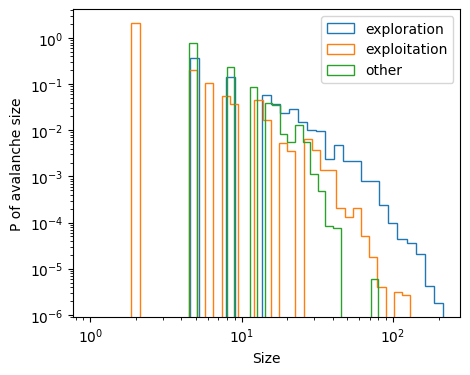

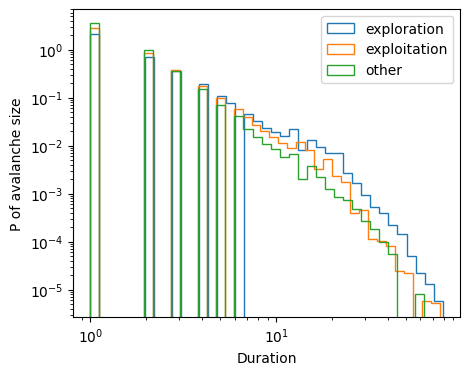

In [261]:
raster_exp, t_edges = bin_spikes(spikes_by_state['exploration'])
raster_expl, _     = bin_spikes(spikes_by_state['exploitation'])
raster_other, _    = bin_spikes(spikes_by_state['other'])

aval_exp = detect_avalanches(raster_exp)
aval_expl = detect_avalanches(raster_expl)
aval_other = detect_avalanches(raster_other)

avals = {'exploration': aval_exp, 'exploitation': aval_expl, 'other': aval_other}

bins_n = 40
overlay_distributions(avals, 'size', bins_n=bins_n)
overlay_distributions(avals, 'duration',bins_n=bins_n)

inter vs pyr

In [262]:
# Your IDs

if date == "20250717":
    pyr_ids = [15,25,34,49,50,58,62,69,73,74,79,81,83,116,129,130,140,146,152,153,175,191,201,221,240,268,379,380,401,419,421,431,432,435,448,451,461,463,467,468,481,482,484,499,500,501,502,503,519,521,524,534,535,542,613]
    inter_ids = [8,12,63,85,104,108,161,178,179,188,189,202,213,255,276,331,480,520,522]

if date == "20250718":
    pyr_ids = [7,26,45,53,56,64,68,79,83,89,90,115,125,137,167,178,183,189,228,230,232,233,234,256,
            403,414,426,427,428,429,430,434,441,444,445,446,455,457,458,460,470,471,472,473,474,
            475,476,477,494,495,512,513,516,519,545]
    inter_ids = [70,78,105,110,138,153,154,204,220,227,492,493]

# Split
spikes_pyr, spikes_inter = split_spikes_by_celltype(spikes_by_state, pyr_ids, inter_ids)

In [263]:
# For pyramidal neurons

bin_size = 0.02

r_pyr_exp, _  = bin_spikes(spikes_pyr['exploration'], bin_size=bin_size)
r_pyr_expl, _ = bin_spikes(spikes_pyr['exploitation'], bin_size=bin_size)
r_pyr_other, _= bin_spikes(spikes_pyr['other'], bin_size=bin_size)

aval_pyr_exp   = detect_avalanches(r_pyr_exp)
aval_pyr_expl  = detect_avalanches(r_pyr_expl)
aval_pyr_other = detect_avalanches(r_pyr_other)

# For interneurons
r_int_exp, _  = bin_spikes(spikes_inter['exploration'], bin_size=bin_size)
r_int_expl, _ = bin_spikes(spikes_inter['exploitation'], bin_size=bin_size)
r_int_other, _= bin_spikes(spikes_inter['other'], bin_size=bin_size)

aval_int_exp   = detect_avalanches(r_int_exp)
aval_int_expl  = detect_avalanches(r_int_expl)
aval_int_other = detect_avalanches(r_int_other)

In [264]:
# Build dicts for plotting
pyr_avals = {
    'exploration': aval_pyr_exp,
    'exploitation': aval_pyr_expl,
    'other': aval_pyr_other
}

inter_avals = {
    'exploration': aval_int_exp,
    'exploitation': aval_int_expl,
    'other': aval_int_other
}

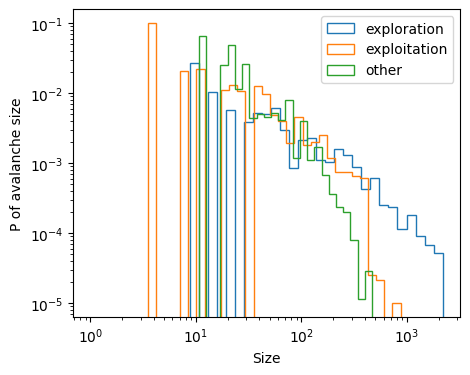

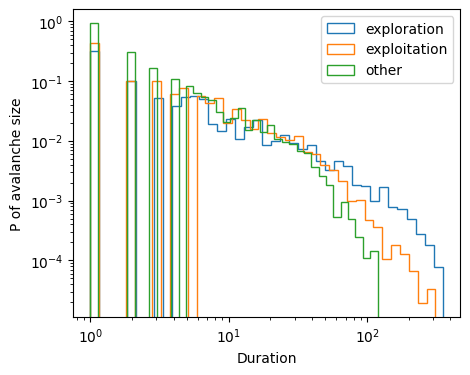

In [265]:
bins_n = 40
a = inter_avals
overlay_distributions(a, 'size', bins_n=bins_n)
overlay_distributions(a, 'duration',bins_n=bins_n)

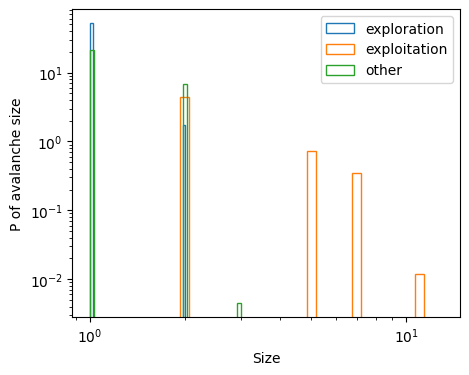

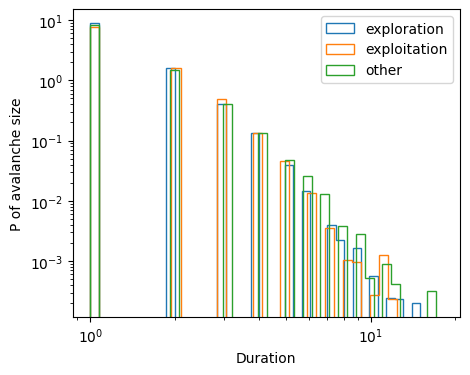

In [266]:
bins_n = 40
a = pyr_avals
overlay_distributions(a, 'size', bins_n=bins_n)
overlay_distributions(a, 'duration',bins_n=bins_n)